In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Simulate system behavior data (CPU, Memory, Disk, Network Traffic, Temperature)
np.random.seed(42)
time_steps = 2000

# Simulate normal behavior for each parameter
normal_cpu = np.sin(np.linspace(0, 50, time_steps)) * 20 + 60  # Simulated normal CPU usage (60% +- 20%)
normal_memory = np.cos(np.linspace(0, 50, time_steps)) * 10 + 50  # Simulated normal memory usage (50% +- 10%)
normal_disk = np.sin(np.linspace(0, 50, time_steps)) * 15 + 70  # Simulated normal disk usage (70% +- 15%)
normal_network = np.cos(np.linspace(0, 50, time_steps)) * 5 + 100  # Simulated normal network traffic (100 KB/s +- 5KB)
normal_temperature = np.sin(np.linspace(0, 50, time_steps)) * 3 + 40  # Simulated normal temperature (40°C +- 3°C)

In [3]:
# Introduce some anomalies
anomalies_cpu = np.copy(normal_cpu)
anomalies_cpu[300:350] = 90  # Simulate a CPU spike anomaly
anomalies_cpu[800:850] = 10  # Simulate a CPU dip anomaly

anomalies_memory = np.copy(normal_memory)
anomalies_memory[1200:1250] = 30  # Simulate a memory spike anomaly

anomalies_disk = np.copy(normal_disk)
anomalies_disk[600:650] = 50  # Simulate a disk usage spike anomaly

anomalies_network = np.copy(normal_network)
anomalies_network[1500:1550] = 140  # Simulate a network traffic anomaly

anomalies_temperature = np.copy(normal_temperature)
anomalies_temperature[500:550] = 55  # Simulate a temperature spike anomaly

# Combine all parameters into a dataframe
data = pd.DataFrame({
    'CPU': anomalies_cpu, 
    'Memory': anomalies_memory,
    'Disk': anomalies_disk,
    'Network': anomalies_network,
    'Temperature': anomalies_temperature
})

In [4]:
data.head()

,CPU,Memory,Disk,Network,Temperature
0,60.000000,60.000000,70.000000,105.000000,40.000000
1,60.500198,59.996872,70.375148,104.998436,40.075030
2,61.000083,59.987490,70.750062,104.993745,40.150012
3,61.499342,59.971860,71.124507,104.985930,40.224901
4,61.997664,59.949992,71.498248,104.974996,40.299650


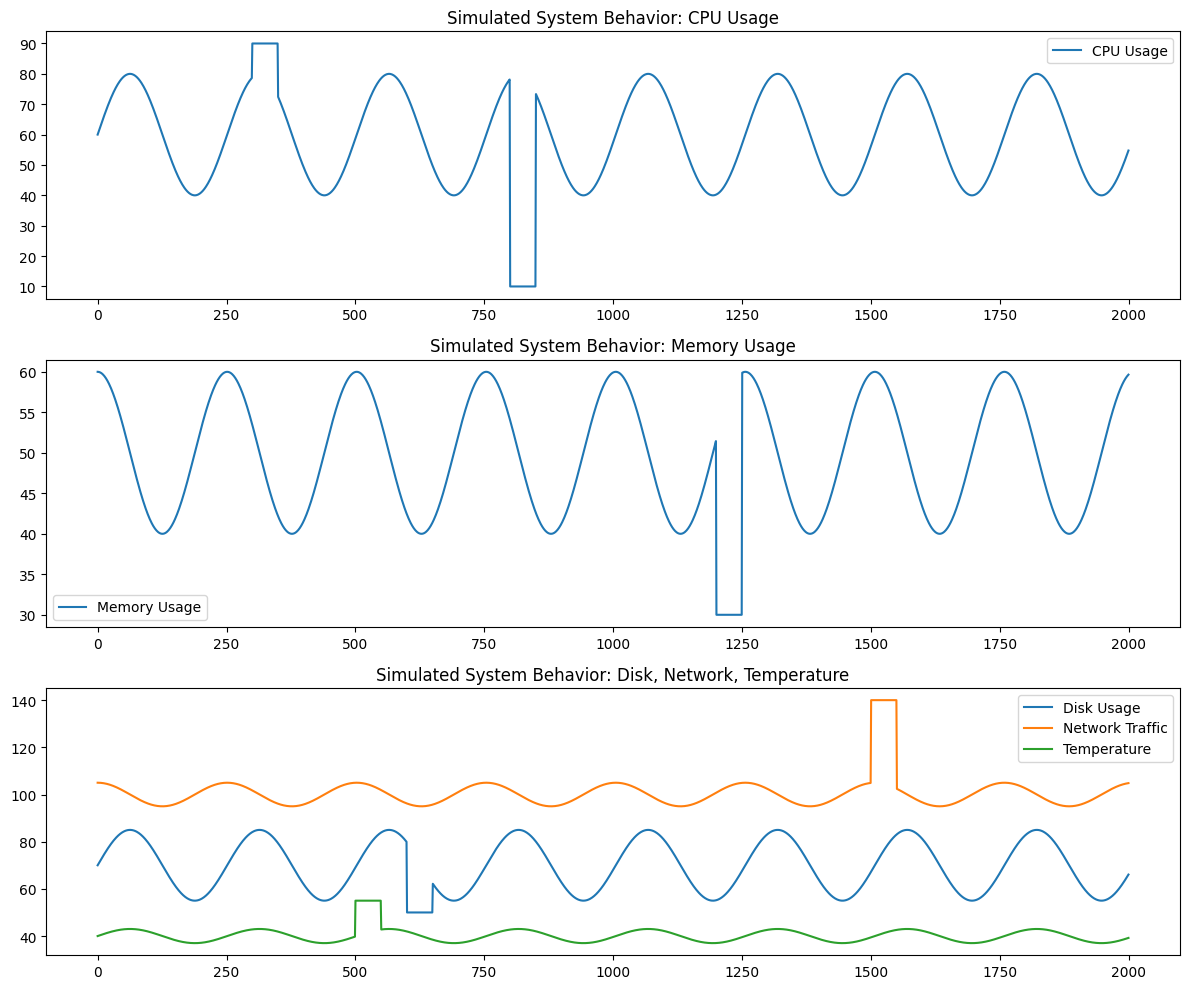

In [5]:
# Plot the data
plt.figure(figsize=(12, 10))
plt.subplot(3, 1, 1)
plt.plot(data['CPU'], label="CPU Usage")
plt.title("Simulated System Behavior: CPU Usage")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(data['Memory'], label="Memory Usage")
plt.title("Simulated System Behavior: Memory Usage")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(data['Disk'], label="Disk Usage")
plt.plot(data['Network'], label="Network Traffic")
plt.plot(data['Temperature'], label="Temperature")
plt.title("Simulated System Behavior: Disk, Network, Temperature")
plt.legend()

plt.tight_layout()
plt.show()

In [6]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

In [7]:
# Function to create sequences from the data
def create_sequences(data, seq_length):
    X = []
    Y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        Y.append(data[i+seq_length])  # Next point in the sequence (multivariate)
    return np.array(X), np.array(Y)

# Parameters
seq_length = 50  # Number of previous time steps to consider
X, Y = create_sequences(data_scaled, seq_length)

# Split the data into training and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, Y_train = X[:train_size], Y[:train_size]
X_test, Y_test = X[train_size:], Y[train_size:]

In [8]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

# Create DataLoader for batching
train_data = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)


In [9]:
import torch.nn as nn
import torch.optim as optim

class LSTMAnomalyModel(nn.Module):
    def __init__(self, input_size=5, hidden_size=64, output_size=5):  # 5 features: CPU, Memory, Disk, Network, Temperature
        super(LSTMAnomalyModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)  # Predict all 5 parameters
    
    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Only take the output of the last time step
        return out

# Initialize the model
model = LSTMAnomalyModel()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [10]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for X_batch, Y_batch in train_loader:
        # Forward pass
        optimizer.zero_grad()
        Y_pred = model(X_batch)
        
        # Compute loss
        loss = criterion(Y_pred, Y_batch)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader)}')


Epoch 1/10, Loss: 0.08617634611318306
Epoch 2/10, Loss: 0.01966204755578418
Epoch 3/10, Loss: 0.010011765283855553
Epoch 4/10, Loss: 0.007011485466619535
Epoch 5/10, Loss: 0.004419815498499238
Epoch 6/10, Loss: 0.003382060568713184
Epoch 7/10, Loss: 0.0031091288309449292
Epoch 8/10, Loss: 0.002745511202136891
Epoch 9/10, Loss: 0.002574217259855371
Epoch 10/10, Loss: 0.0023140037118704344


In [11]:
# Switch model to evaluation mode
model.eval()

# Make predictions on the test set
with torch.no_grad():
    Y_pred_test = model(X_test_tensor)

# Convert predictions to numpy for evaluation
Y_pred_test = Y_pred_test.numpy()
Y_test = Y_test_tensor.numpy()

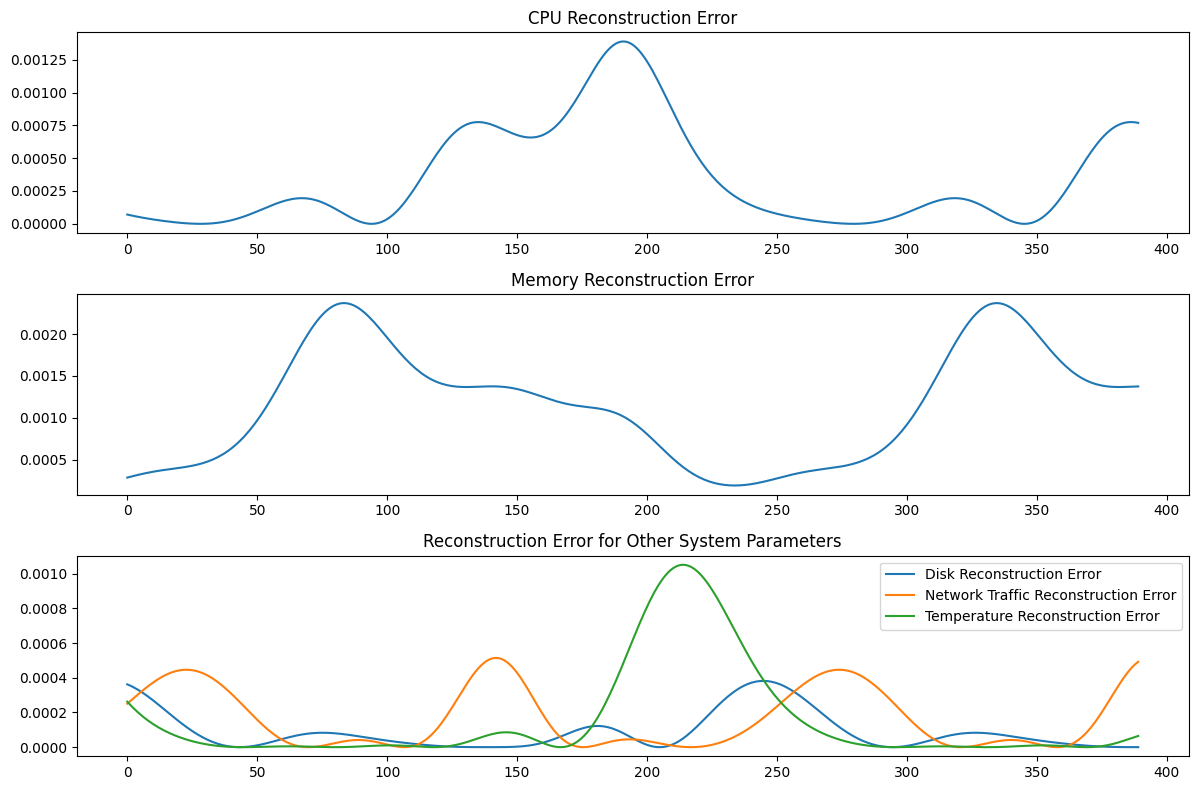

Mean MSE (CPU): 0.0003441315784584731
Mean MSE (Memory): 0.0011495997896417975
Mean MSE (Disk): 8.597683336120099e-05
Mean MSE (Network): 0.00016868725651875138
Mean MSE (Temperature): 0.00015133098349906504


In [12]:
# Ensure predictions and ground truth have the correct shape
Y_pred_test = Y_pred_test.reshape(-1, 5)  # Reshape to (num_samples, num_features)
Y_test = Y_test.reshape(-1, 5)            # Reshape to (num_samples, num_features)

# Calculate reconstruction error (MSE for each feature) over all samples
mse_cpu = np.square(Y_test[:, 0] - Y_pred_test[:, 0])  # CPU MSE
mse_memory = np.square(Y_test[:, 1] - Y_pred_test[:, 1])  # Memory MSE
mse_disk = np.square(Y_test[:, 2] - Y_pred_test[:, 2])    # Disk MSE
mse_network = np.square(Y_test[:, 3] - Y_pred_test[:, 3])  # Network MSE
mse_temperature = np.square(Y_test[:, 4] - Y_pred_test[:, 4])  # Temperature MSE

# If you want to calculate the mean squared error over the whole sequence, you can do:
mean_mse_cpu = np.mean(mse_cpu)
mean_mse_memory = np.mean(mse_memory)
mean_mse_disk = np.mean(mse_disk)
mean_mse_network = np.mean(mse_network)
mean_mse_temperature = np.mean(mse_temperature)

# Plot the reconstruction error for each feature
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(mse_cpu, label="CPU Reconstruction Error")
plt.title("CPU Reconstruction Error")

plt.subplot(3, 1, 2)
plt.plot(mse_memory, label="Memory Reconstruction Error")
plt.title("Memory Reconstruction Error")

plt.subplot(3, 1, 3)
plt.plot(mse_disk, label="Disk Reconstruction Error")
plt.plot(mse_network, label="Network Traffic Reconstruction Error")
plt.plot(mse_temperature, label="Temperature Reconstruction Error")
plt.title("Reconstruction Error for Other System Parameters")
plt.legend()

plt.tight_layout()
plt.show()

# Optionally, calculate the overall mean errors
print(f"Mean MSE (CPU): {mean_mse_cpu}")
print(f"Mean MSE (Memory): {mean_mse_memory}")
print(f"Mean MSE (Disk): {mean_mse_disk}")
print(f"Mean MSE (Network): {mean_mse_network}")
print(f"Mean MSE (Temperature): {mean_mse_temperature}")


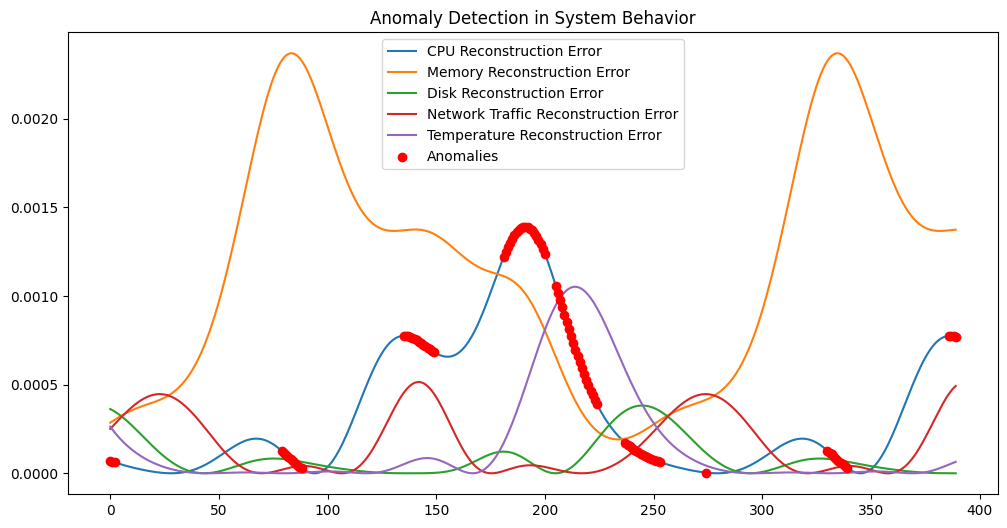

In [13]:
# Set thresholds (e.g., using the 95th percentile of the error)
threshold_cpu = np.percentile(mse_cpu, 95)
threshold_memory = np.percentile(mse_memory, 95)
threshold_disk = np.percentile(mse_disk, 95)
threshold_network = np.percentile(mse_network, 95)
threshold_temperature = np.percentile(mse_temperature, 95)

# Detect anomalies
anomalies_cpu = mse_cpu > threshold_cpu
anomalies_memory = mse_memory > threshold_memory
anomalies_disk = mse_disk > threshold_disk
anomalies_network = mse_network > threshold_network
anomalies_temperature = mse_temperature > threshold_temperature

# Combine anomalies from all parameters
anomalies = anomalies_cpu | anomalies_memory | anomalies_disk | anomalies_network | anomalies_temperature

# Plot anomalies on the error plot
plt.figure(figsize=(12, 6))
plt.plot(mse_cpu, label="CPU Reconstruction Error")
plt.plot(mse_memory, label="Memory Reconstruction Error")
plt.plot(mse_disk, label="Disk Reconstruction Error")
plt.plot(mse_network, label="Network Traffic Reconstruction Error")
plt.plot(mse_temperature, label="Temperature Reconstruction Error")
plt.scatter(np.where(anomalies), mse_cpu[anomalies], color='red', label="Anomalies", zorder=5)
plt.title("Anomaly Detection in System Behavior")
plt.legend()
plt.show()
